[View in Colaboratory](https://colab.research.google.com/github/MaxGhenis/taxcalc-notebooks/blob/master/quantile_regression_comparison_cps.ipynb)

>[Quantile regression from OLS to TensorFlow](#scrollTo=PQdJbWCS9N3G)

>>[Setup](#scrollTo=VjvK4vP2-X_D)

>>>[Graph options](#scrollTo=sm3RTN850S70)

>>>[Data](#scrollTo=vdaqXkSCe7gG)

>>>>[Load](#scrollTo=vdaqXkSCe7gG)

>>>>[Randomize and split](#scrollTo=80yZ1lihmLQq)

>>>>[Normalize](#scrollTo=xuphFNDqtEiW)

>>>[Initialize result](#scrollTo=utzAT-gdBTqj)

>>[OLS](#scrollTo=6dRLoTDhCrpO)

>>[QuantReg](#scrollTo=esTAKyTyG1TS)

>>[Random forests](#scrollTo=qCt2S4V9Uepc)

>>[Gradient boosted trees](#scrollTo=6ssXXxsCA7FS)

>>[Keras](#scrollTo=H55y_74W97jH)

>>[TensorFlow](#scrollTo=PEy2M6X89tbD)

>>[Compare quantile loss](#scrollTo=42LIBXl933YI)



# Quantile regression from OLS to TensorFlow

Use the [CPS data.](https://github.com/open-source-economics/taxdata/blob/master/cps_data/cps.csv.gz)

Based on blog posts using:
* Keras: https://towardsdatascience.com/deep-quantile-regression-c85481548b5a
* Tensorflow: https://towardsdatascience.com/deep-quantile-regression-in-tensorflow-1dbc792fe597
* statsmodels quantile regression: https://www.statsmodels.org/dev/examples/notebooks/generated/quantile_regression.html

## Setup

In [2]:
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm

from scipy.stats import norm

from sklearn import ensemble
from sklearn.model_selection import train_test_split
from sklearn import linear_model

import tensorflow as tf
from tensorflow import keras

/usr/local/lib/python3.6/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Random forest and GBM options.

In [0]:
N_ESTIMATORS = 200

Keras and TensorFlow options

In [0]:
EPOCHS = 20
BATCH_SIZE = 32
UNITS = 64

### Graph options

In [5]:
!wget https://github.com/MaxGhenis/random/raw/master/Roboto-Regular.ttf -P /usr/local/lib/python3.6/dist-packages/matplotlib/mpl-data/fonts/ttf
mpl.font_manager._rebuild()


Redirecting output to ‘wget-log’.


In [0]:
sns.set_style('white')
DPI = 200
mpl.rc('savefig', dpi=DPI)
mpl.rcParams['figure.dpi'] = DPI
mpl.rcParams['figure.figsize'] = 6.4, 4.8  # Default.
mpl.rcParams['font.sans-serif'] = 'Roboto'
mpl.rcParams['font.family'] = 'sans-serif'

# Set title text color to dark gray (https://material.io/color) not black.
TITLE_COLOR = '#212121'
mpl.rcParams['text.color'] = TITLE_COLOR

# Axis titles and tick marks are medium gray.
AXIS_COLOR = '#757575'
mpl.rcParams['axes.labelcolor'] = AXIS_COLOR
mpl.rcParams['xtick.color'] = AXIS_COLOR
mpl.rcParams['ytick.color'] = AXIS_COLOR

### Data

#### Load

In [7]:
!wget -N https://github.com/open-source-economics/taxdata/raw/master/cps_data/cps.csv.gz
!gunzip -f cps.csv.gz


Redirecting output to ‘wget-log.1’.


In [0]:
raw = pd.read_csv('cps.csv')

### Preprocess

Select only common variables.

In [0]:
TARGET = 'e00900'

In [0]:
dat = raw.copy(deep=True)

Feature engineering.

In [0]:
# CPS data has MARS values of 1, 2, and 4.
dat[['MARS2', 'MARS4']] = pd.get_dummies(dat.MARS, drop_first=True)

In [0]:
dat['e19800_e20100'] = dat.e19800 + dat.e20100

In [0]:
PREDICTORS =  ['DSI', 'EIC', 'MARS2', 'MARS4', 'XTOT', 
               'e00200', 'e00300', 'e00400', 'e00600', 'e00800',
               'e01400', 'e01500', 'e01700', 'e02100', 'e02300', 'e02400', 
               'e03150', 'e03210', 'e03240', 'e03270', 'e03300', 'e17500', 
               'e18400', 'e18500', 'e19200', 'e19800_e20100', 'e20400', 
               'e32800', 'f2441', 'n24', 'e01100']

In [0]:
dat = dat[PREDICTORS + [TARGET]]

Create log-transformed version. Calculate y later.

In [0]:
LOG_PREDICTORS = ['e00200', 'e00300', 'e00400', 'e00600', 'e00800',
                  'e01400', 'e01500', 'e01700', 'e02100', 'e02300', 'e02400', 
                  'e03150', 'e03210', 'e03240', 'e03270', 'e03300', 'e17500', 
                  'e18400', 'e18500', 'e19200', 'e19800_e20100', 'e20400', 
                  'e32800', 'e01100']

In [0]:
for i in LOG_PREDICTORS:
  dat[i + '_log'] = np.log(dat[i] - dat[i].min() + 1)

#### Randomize and split

Initial order may or may not be random.

In [0]:
X_train_full, X_test_full, y_train, y_test = train_test_split(
    dat.drop(TARGET, axis=1), dat[TARGET], test_size=0.2, random_state=42)

#### Normalize

In [0]:
mean = X_train_full.mean(axis=0)
std = X_train_full.std(axis=0)
X_train_full_std = (X_train_full - mean) / std
X_test_full_std = (X_test_full - mean) / std

Separate into standard and log versions.

In [0]:
X_train = X_train_full_std[PREDICTORS]
X_test = X_test_full_std[PREDICTORS]

X_train_log = X_train_full_std.drop(PREDICTORS, axis=1)
X_test_log = X_test_full_std.drop(PREDICTORS, axis=1)

Reformat data for `statsmodels`.

In [0]:
X_train_w_constant = sm.add_constant(X_train)
X_test_w_constant = sm.add_constant(X_test)

X_train_log_w_constant = sm.add_constant(X_train_log)
X_test_log_w_constant = sm.add_constant(X_test_log)

Reformat 1-column data for `tensorflow`.

In [0]:
y_train_expanded = np.expand_dims(y_train, 1)

#### Data for two-stage logit+OLS

Log features.

In [0]:
y_train_sign = np.sign(y_train)
y_train_pos = y_train[y_train > 0]
y_train_pos_log = np.log(y_train_pos)
X_train_log_w_constant_pos = X_train_log_w_constant[y_train > 0]
y_train_neg = y_train[y_train < 0]
y_train_neg_log = np.log(-y_train_neg)
X_train_log_w_constant_neg = X_train_log_w_constant[y_train < 0]

### Initialize result

Dataset per method, quantile, and `x` value.

In [0]:
METHODS = ['OLS', 'LogitOLS', 'QuantReg', 'Random forests', 'Gradient boosting', 'Keras',
           'TensorFlow']

QUANTILES = [0.1, 0.3, 0.5, 0.7, 0.9]

quantiles_legend = [str(int(q * 100)) + 'th percentile' for q in QUANTILES]

In [0]:
# sns.set_palette(sns.color_palette('Blues', len(QUANTILES)))
sns.set_palette(sns.color_palette('Blues'))
# Set dots to a light gray
dot_color = sns.color_palette('coolwarm', 3)[1]

In [0]:
preds = np.array([(method, q, ix) 
                  for method in METHODS 
                  for q in QUANTILES
                  for ix in y_test.index])
preds = pd.DataFrame(preds)
preds.columns = ['method', 'q', 'ix']
preds['label'] = np.resize(y_test, preds.shape[0])
preds = preds.apply(lambda x: pd.to_numeric(x, errors='ignore'))

## OLS

https://stackoverflow.com/questions/17559408/confidence-and-prediction-intervals-with-statsmodels

In [0]:
ols = sm.OLS(y_train, X_train_w_constant).fit()

In [0]:
def ols_quantile(m, X, q):
  # m: OLS model.
  # X: X matrix.
  # q: Quantile.
  #
  # Set alpha based on q. Vectorized for different values of q.
  mean_pred = m.predict(X)
  se = np.sqrt(m.scale)
  return mean_pred + norm.ppf(q) * se

In [0]:
preds.loc[preds.method == 'OLS', 'pred'] = np.concatenate(
    [ols_quantile(ols, X_test_w_constant, q) for q in QUANTILES]) 

## Logit + OLS

Predict the sign (negative/zero/positive), then apply log regressions.

See [taxdata #221](https://github.com/open-source-economics/taxdata/issues/221), [taxdata #267](https://github.com/open-source-economics/taxdata/issues/267), [taxdata #275](https://github.com/open-source-economics/taxdata/pull/275), [my notebook](http://nbviewer.jupyter.org/github/MaxGhenis/taxcalc-notebooks/blob/master/exploratory/random_forests_imputation.ipynb), and [Avi Leventhal's notebook](http://nbviewer.jupyter.org/github/Abraham-Leventhal/taxdata/blob/Abraham-Leventhal-patch-1/cps_data/Imputation%20Project/P22250%20Full%20Imputation%20RF%20vs%20mnlogitOLS.ipynb).

Segment into positive and negative.


In [125]:
mult = linear_model.LogisticRegression(
    multi_class='multinomial', solver='newton-cg', random_state=3)
mult.fit(X_train_log, y_train_sign)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=3, solver='newton-cg',
          tol=0.0001, verbose=0, warm_start=False)

In [0]:
ols_pos = sm.OLS(y_train_pos_log, X_train_log_w_constant_pos).fit()
ols_neg = sm.OLS(y_train_neg_log, X_train_log_w_constant_neg).fit()

### Predict

In [0]:
mult_probs = mult.predict_proba(X_test_log)

In [0]:
test_logit_ols = pd.DataFrame({
    'neg_prob': mult_probs[:, 0],
    'zero_prob': mult_probs[:, 1],
    'neg_pred': ols_neg.predict(X_test_log_w_constant),
    'neg_se': np.sqrt(ols_neg.scale),
    'pos_pred': ols_pos.predict(X_test_log_w_constant),
    'pos_se': np.sqrt(ols_pos.scale)
})

In [0]:
def ols_q(mean, q, se):
  return mean + norm.ppf(q) * se

In [0]:
def mult_ols_quantile(df, q):
  # df: DataFrame with columns for neg_prob, zero_prob, neg_pred, neg_se, 
  #     pos_pred, and pos_se.
  # q: Quantile.
  #
  # Calculate the quantile within each OLS model.
  neg_q = q / df.neg_prob
  pos_q = (q - df.neg_prob - df.zero_prob) / (1 - df.neg_prob - df.zero_prob)
  sign = np.where(q < df.neg_prob, -1, 
                  np.where(q < (df.neg_prob + df.zero_prob), 0, 1))
  return np.where(sign == -1, -np.exp(ols_q(df.neg_pred, neg_q, df.neg_se)),
                  np.where(sign == 1, 
                           np.exp(ols_q(df.pos_pred, pos_q, df.pos_se)),
                           0))

In [0]:
preds.loc[preds.method == 'LogitOLS', 'pred'] = np.concatenate(
    [mult_ols_quantile(test_logit_ols, q) for q in QUANTILES]) 

## QuantReg

https://www.statsmodels.org/dev/examples/notebooks/generated/quantile_regression.html

In [0]:
# Don't fit yet, since we'll fit once per quantile.
quantreg = sm.QuantReg(y_train, X_train_w_constant)

In [0]:
preds.loc[preds.method == 'QuantReg', 'pred'] = np.concatenate(
    [quantreg.fit(q=q).predict(X_test_w_constant) for q in QUANTILES]) 

## Random forests

In [37]:
rf = ensemble.RandomForestRegressor(n_estimators=N_ESTIMATORS, 
                                    min_samples_leaf=1, random_state=3, 
                                    verbose=True, 
                                    n_jobs=-1)  # Use maximum number of cores.
rf.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed: 16.0min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed: 16.3min finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
           oob_score=False, random_state=3, verbose=True, warm_start=False)

In [0]:
def rf_quantile(m, X, q):
    rf_preds = []
    for estimator in m.estimators_:
        rf_preds.append(estimator.predict(X))
    rf_preds = np.array(rf_preds).transpose()  # One row per record.
    return np.percentile(rf_preds, q * 100, axis=1)

In [0]:
preds.loc[preds.method == 'Random forests', 'pred'] = np.concatenate(
    [rf_quantile(rf, X_test, q) for q in QUANTILES]) 

## Gradient boosted trees

In [0]:
def gb_quantile(X_train, train_labels, X, q):
  print(q)
  gbf = ensemble.GradientBoostingRegressor(loss='quantile', alpha=q,
                                           n_estimators=N_ESTIMATORS,
                                           max_depth=3,
                                           verbose=True,
                                           learning_rate=0.1, 
                                           min_samples_leaf=9,
                                           min_samples_split=9)
  gbf.fit(X_train, train_labels)
  return gbf.predict(X)

In [41]:
preds.loc[preds.method == 'Gradient boosting', 'pred'] = np.concatenate(
    [gb_quantile(X_train, y_train, X_test, q)
     for q in QUANTILES])

0.1
      Iter       Train Loss   Remaining Time 
         1        1035.2734            2.26m
         2        1035.2734            2.23m
         3        1035.2734            2.23m
         4        1035.2734            2.22m
         5        1035.2734            2.22m
         6        1035.2734            2.22m
         7        1035.2734            2.22m
         8        1035.2734            2.22m
         9        1035.2734            2.21m
        10        1035.2734            2.21m
        20        1035.2734            2.10m
        30        1035.2734            2.00m
        40        1035.2734            1.90m
        50        1035.2734            1.78m
        60        1035.2734            1.66m
        70        1035.2734            1.54m
        80        1035.2734            1.42m
        90        1035.2734            1.30m
       100        1035.2734            1.18m
       200        1035.2734            0.00s
0.3
      Iter       Train Loss   Remaining Time 


## Keras

From https://github.com/sachinruk/KerasQuantileModel/blob/master/Keras%20Quantile%20Model.ipynb

One area that Deep Learning has not explored extensively is the uncertainty in estimates. However, as far as decision making goes, most people actually require quantiles as opposed to true uncertainty in an estimate. eg. For a given age the weight of an individual will vary. What would be interesting is the (for arguments sake) the 10th and 90th percentile. The uncertainty of the estimate of an individuals weight is less interesting.

In [0]:
def tilted_loss(q, y, f):
    e = (y - f)
    return keras.backend.mean(keras.backend.maximum(q * e, (q - 1) * e), 
                              axis=-1)

In [0]:
optimizer = tf.train.AdamOptimizer(0.001)
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

In [0]:
sess = tf.Session()
#tf.reset_default_graph()

In [0]:
def keras_pred(x_train, train_labels, x_test, q):
    print(q)
#     optimizer = tf.train.AdamOptimizer(0.001)
#     early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
    # Set input_dim for the number of features.
    if len(x_train.shape) == 1:
        input_dim = 1
    else:
        input_dim = x_train.shape[1]
    model = keras.Sequential([
      keras.layers.Dense(UNITS, activation=tf.nn.relu,
                         input_dim=input_dim),
      keras.layers.Dense(UNITS, activation=tf.nn.relu),
      keras.layers.Dense(1)
    ])
    
    model.compile(loss=lambda y, f: tilted_loss(q, y, f), optimizer=optimizer)
    model.fit(x_train, train_labels, epochs=EPOCHS, batch_size=BATCH_SIZE,
              verbose=0, validation_split=0.2, callbacks=[early_stop])
    
    # Predict the quantile
    return model.predict(x_test)

In [46]:
preds.loc[preds.method == 'Keras', 'pred'] = np.concatenate(
    [keras_pred(X_train, y_train, X_test, q) 
     for q in QUANTILES])

0.1
0.3
0.5
0.7
0.9


## TensorFlow

Adapted from https://github.com/strongio/quantile-regression-tensorflow/blob/master/Quantile%20Loss.ipynb

In [0]:
# Initialize session
tf.reset_default_graph()
sess = tf.Session()

In [0]:
# Create network
class q_model:
    def __init__(self, 
                 sess,
                 quantiles,
                 in_shape=1, 
                 out_shape=1, 
                 batch_size=32):
        
#         tf.reset_default_graph()
        
        self.sess = sess
        
        self.quantiles = quantiles
        self.num_quantiles = len(quantiles)
        
        self.in_shape = in_shape
        self.out_shape = out_shape
        self.batch_size = batch_size
        
        self.outputs = []
        self.losses = []
        self.loss_history = []
        
        self.build_model()
        
    def build_model(self, scope='q_model', reuse=tf.AUTO_REUSE): 
        with tf.variable_scope(scope, reuse=reuse) as scope:
            self.x = tf.placeholder(tf.float32, shape=(None, self.in_shape))
            self.y = tf.placeholder(tf.float32, shape=(None, self.out_shape))

            self.layer0 = tf.layers.dense(self.x, 
                                          units=UNITS, 
                                          activation=tf.nn.relu)
            self.layer1 = tf.layers.dense(self.layer0, 
                                          units=UNITS,
                                          activation=tf.nn.relu)

            # Create outputs and losses for all quantiles
            for i, q in enumerate(self.quantiles):
                # Get output layers 
                output = tf.layers.dense(self.layer1, self.out_shape,
                                         name="{}_q{}".format(i, int(q * 100)))
                self.outputs.append(output)
                
                # Create losses
                error = tf.subtract(self.y, output)
                loss = tf.reduce_mean(tf.maximum(q * error, (q - 1) * error),
                                      axis=-1)

                self.losses.append(loss)

            # Create combined loss
            self.combined_loss = tf.reduce_mean(tf.add_n(self.losses))
            self.train_step = tf.train.AdamOptimizer().minimize(
                self.combined_loss)

    def fit(self, x, y, epochs=EPOCHS):
        for epoch in range(epochs):
            epoch_losses = []
            for idx in range(0, x.shape[0], self.batch_size):
                batch_x = x[idx : min(idx + self.batch_size, x.shape[0]), :]
                batch_y = y[idx : min(idx + self.batch_size, y.shape[0]), :]

                feed_dict = {self.x: batch_x,
                             self.y: batch_y}

                _, c_loss = self.sess.run([self.train_step, self.combined_loss],
                                          feed_dict)
                epoch_losses.append(c_loss)
                
            epoch_loss =  np.mean(epoch_losses)
            self.loss_history.append(epoch_loss)
            if epoch % 10 == 0:
                print("Epoch {}: {}".format(epoch, epoch_loss))
            
    def predict(self, x):   
        # Run model to get outputs
        feed_dict = {self.x: x}
        predictions = sess.run(self.outputs, feed_dict)
        
        return predictions

In [0]:
# Instantiate model
tf_model = q_model(sess, quantiles=QUANTILES, in_shape=X_train.shape[1],
                   out_shape=1, batch_size=BATCH_SIZE)

# Initialize all variables
init_op = tf.global_variables_initializer()
sess.run(init_op)

In [50]:
# Run training
tf_model.fit(np.array(X_train), y_train_expanded, EPOCHS)

Epoch 0: 21430.86328125
Epoch 10: 15456.2646484375


In [0]:
preds.loc[preds.method == 'TensorFlow', 'pred'] = \
    np.array([item for sublist in tf_model.predict(X_test)
              for item in sublist])

## Compare quantile loss

In [0]:
# pandas version rather than Keras.
def quantile_loss(q, y, f):
    e = (y - f)
    return np.maximum(q * e, (q - 1) * e)

In [0]:
preds['quantile_loss'] = quantile_loss(preds.q, preds.label, preds.pred)

In [0]:
def plot_loss_comparison(preds):
  overall_loss_comparison = preds[~preds.quantile_loss.isnull()].\
    pivot_table(index='method', values='quantile_loss').\
    sort_values('quantile_loss')
  # Show overall table.
  print(overall_loss_comparison)
  
  # Plot overall.
  with sns.color_palette('Blues', 1):
    ax = overall_loss_comparison.plot.barh()
    plt.title('Total quantile loss', loc='left')
    sns.despine(left=True, bottom=True)
    plt.xlabel('Quantile loss')
    plt.ylabel('')
    ax.legend_.remove()
  
  # Per quantile.
  per_quantile_loss_comparison = preds[~preds.quantile_loss.isnull()].\
    pivot_table(index='q', columns='method', values='quantile_loss')
  # Sort by overall quantile loss.
  per_quantile_loss_comparison = \
    per_quantile_loss_comparison[overall_loss_comparison.index]
  print(per_quantile_loss_comparison)
  
  # Plot per quantile.
  with sns.color_palette('Blues', 7):
    ax = per_quantile_loss_comparison.plot.barh()
    plt.title('Quantile loss per quantile', loc='left')
    sns.despine(left=True, bottom=True)
    handles, labels = ax.get_legend_handles_labels()
    plt.xlabel('Quantile loss')
    plt.ylabel('Quantile')
    # Reverse legend.
    ax.legend(reversed(handles), reversed(labels));

                   quantile_loss
method                          
Random forests       1780.631185
Keras                2902.365968
TensorFlow           2947.832552
Gradient boosting    3714.276605
LogitOLS             4143.752395
QuantReg             4344.568016
OLS                 11349.309620
method  Random forests        Keras   TensorFlow  Gradient boosting  \
q                                                                     
0.1         733.596181  1001.585328   988.429851        1001.582703   
0.3        1582.886857  2314.623860  2355.565532        2796.654666   
0.5        2109.426515  3460.318307  3408.195883        4502.006050   
0.7        2404.227426  4078.920450  4150.995083        5600.271240   
0.9        2073.018947  3656.381897  3835.976413        4670.868368   

method     LogitOLS     QuantReg           OLS  
q                                               
0.1     1035.972781  1001.582703   9589.040988  
0.3     2931.184005  2836.598634  12109.529109  
0.5     4

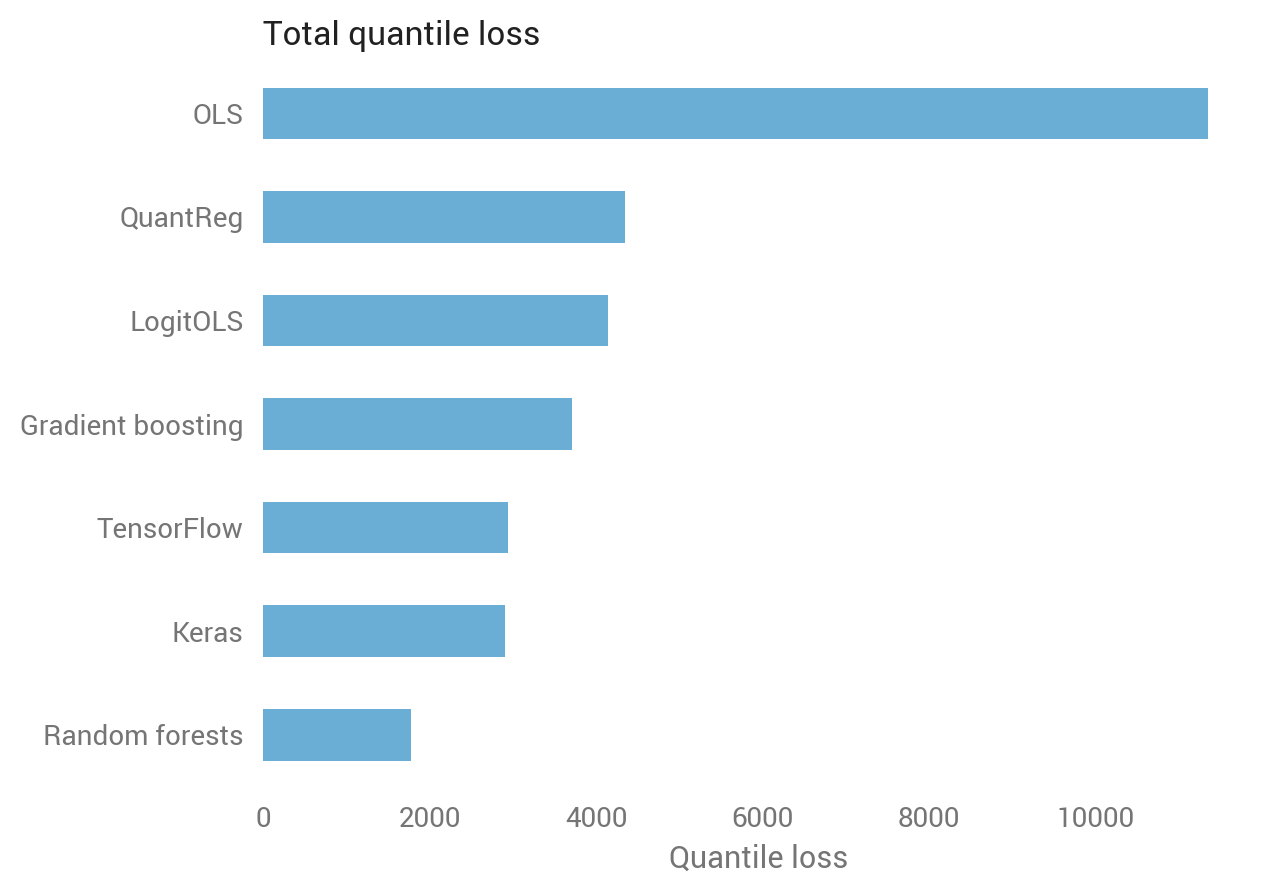

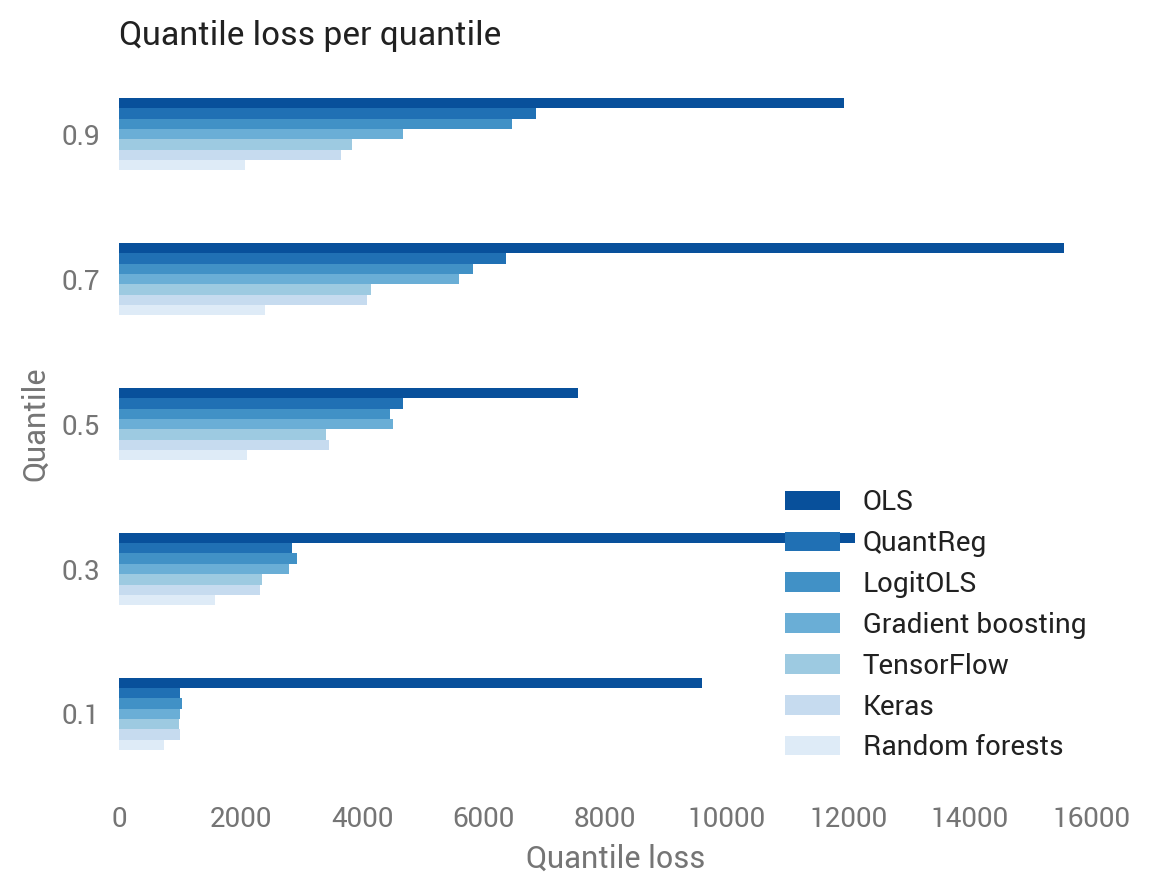

In [136]:
plot_loss_comparison(preds)

Examine individual predictions.

In [0]:
worst_logitols = preds[preds.method == 'LogitOLS'] \
  .sort_values('quantile_loss', ascending=False).head(1)
worst_logitols_ix = worst_logitols['ix'].values[0]
worst_logitols_label = worst_logitols['label'].values[0]

In [0]:
example = preds[(preds['ix'] == worst_logitols_ix) &
                (preds.method.isin(['OLS', 'LogitOLS', 'Random forests']))]

In [0]:
example_pivot = example.pivot_table('pred', 'q', 'method')

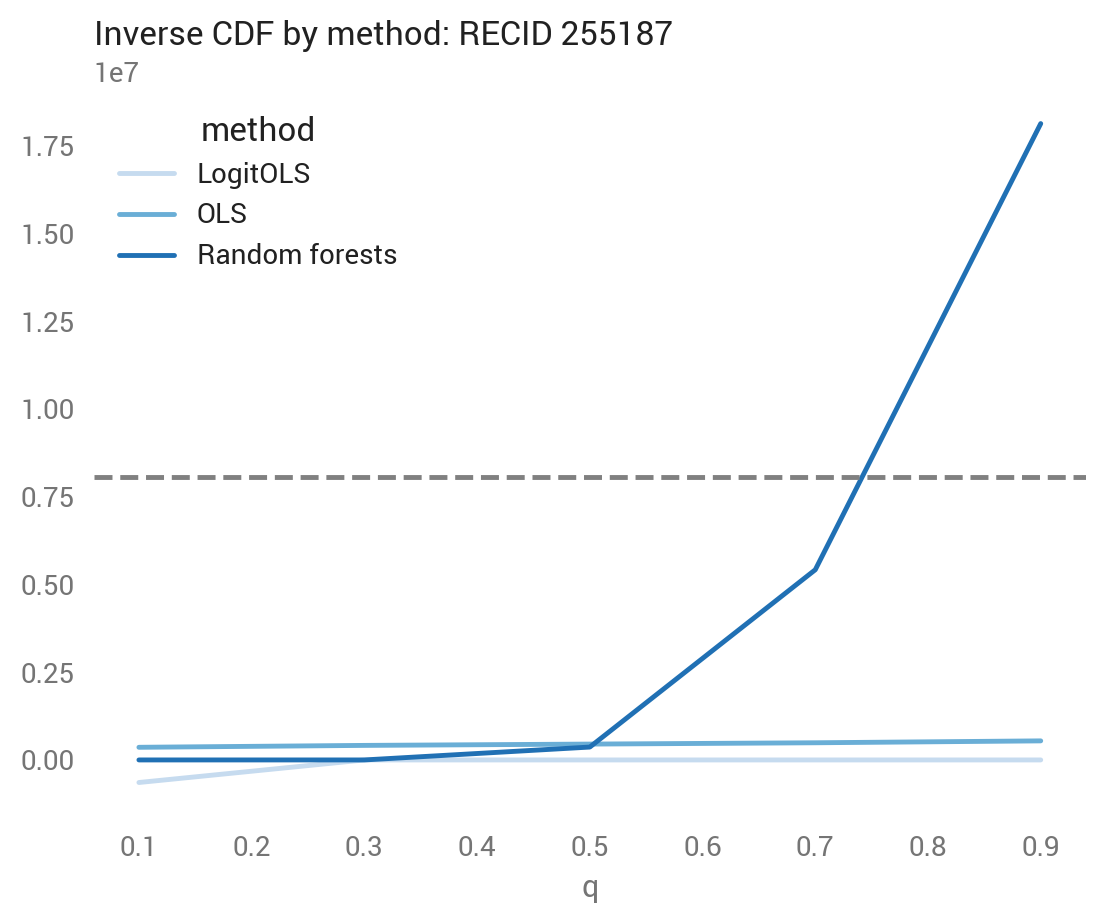

In [203]:
with sns.color_palette('Blues', 3):
  example_pivot.plot()
  sns.despine(left=True, bottom=True)
  plt.title('Inverse CDF by method: RECID ' + worst_logitols_ix.astype(str),
            loc='left', y=1.04)
  plt.axhline(worst_logitols_label, color='gray', ls='dashed')